In [2]:
!pip install catboost
!pip install mplsoccer
!pip install koreanize-matplotlib
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [3]:
import pandas as pd
import os
import numpy as np
import math
from tqdm import tqdm
from pathlib import Path
from mplsoccer import Pitch

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GroupKFold

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arc
import matplotlib.patches as mpatches

import seaborn as sns

from matplotlib import font_manager, rc
import koreanize_matplotlib


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
os.chdir('/content/drive/MyDrive/DACON/K-League')
os.getcwd()

'/content/drive/MyDrive/DACON/K-League'

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


# 피처 엔지니어링


###데이터 로드 train/test

In [14]:
# Train 원본 로딩
train_df = pd.read_csv("./data/train.csv")
train_df = train_df.sort_values(["game_episode", "time_seconds"]).reset_index(drop=True)
train_df["is_train"] = 1

# Test 원본 로딩
test_meta = pd.read_csv("./data/test.csv")
test_meta["path"] = test_meta["path"].str.replace("./test/", "./data/test/", regex=False)

episode_dfs = []

for _, row in tqdm(test_meta.iterrows(), total=len(test_meta)):
    ep_df = pd.read_csv(row["path"]).reset_index(drop=True)
    ep_df["game_id"] = row["game_id"]
    ep_df["game_episode"] = row["game_episode"]
    ep_df["is_train"] = 0
    episode_dfs.append(ep_df)

test_df = pd.concat(episode_dfs, ignore_index=True)
print(train_df.shape, test_df.shape)

# train + test 병합
df = pd.concat([train_df, test_df], ignore_index=True)
print(df.shape)

use_cols = [
    'game_id',
    'game_day', 'game_date',
    'home_score', 'away_score',
    'venue',
    'home_team_name_ko', 'away_team_name_ko'   # EDA용
]

# match_info 병합
df_match = pd.read_csv("./data/match_info.csv")
df_copy = df.merge(df_match[use_cols], on='game_id', how='left')

In [ ]:
df_copy.to_csv('df.csv', index=False)

In [10]:
# ================여기서부터 시작===================
df_copy = pd.read_csv("./df.csv")
df_copy.columns

Index(['game_id', 'period_id', 'episode_id', 'time_seconds', 'team_id',
       'player_id', 'action_id', 'type_name', 'result_name', 'start_x',
       'start_y', 'end_x', 'end_y', 'is_home', 'game_episode', 'is_train',
       'game_day', 'game_date', 'home_score', 'away_score', 'venue',
       'home_team_name_ko', 'away_team_name_ko'],
      dtype='object')

In [11]:
# 2. 대분류 game_episode(게임 ID + 전ㆍ후반)  / 중분류 time_seconds : 동에피소드 시간순서
if 'type_name' in df_copy.columns:
    df_copy = df_copy.rename(columns={'type_name': 'action_type'})
print("train/test + match_info 병합 = df_copy")
print(df_copy.info())

train/test + match_info 병합 = df_copy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409831 entries, 0 to 409830
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   game_id            409831 non-null  int64  
 1   period_id          409831 non-null  int64  
 2   episode_id         409831 non-null  int64  
 3   time_seconds       409831 non-null  float64
 4   team_id            409831 non-null  int64  
 5   player_id          409831 non-null  int64  
 6   action_id          409831 non-null  int64  
 7   action_type        409831 non-null  object 
 8   result_name        248448 non-null  object 
 9   start_x            409831 non-null  float64
 10  start_y            409831 non-null  float64
 11  end_x              407417 non-null  float64
 12  end_y              407417 non-null  float64
 13  is_home            409831 non-null  bool   
 14  game_episode       409831 non-null  object 
 15  is_train      

In [12]:
df_copy.value_counts("action_type")

,count
action_type,
Pass,204612
Carry,94037
Recovery,31703
Interception,12817
Duel,10154
Tackle,9435
Throw-In,7904
Clearance,7527
Intervention,7044


### 선수 포지션 클러스터링

['Pass' 'Pass_Corner' 'Goal Kick' 'Throw-In' 'Pass_Freekick']


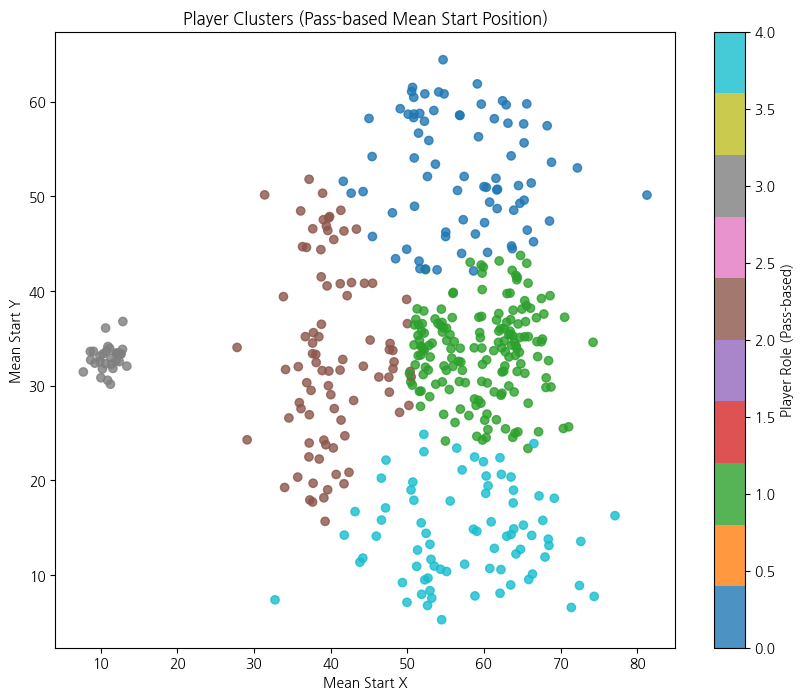

,count
player_role_label,
left_wing,146507
defence,113553
right_wing,65619
attack,59961
mid,23521
unknown,670


In [13]:
# 0. Pass 이벤트만
pass_events = ["Pass", "Pass_Freekick", "Pass_Corner", "Throw-In", "Goal Kick"]
df_pass = df_copy[(df_copy["is_train"] == 1) & (df_copy["action_type"].isin(pass_events))].copy()
print(df_pass['action_type'].unique())

df_pass["dx"] = df_pass["end_x"] - df_pass["start_x"]
df_pass["dy"] = df_pass["end_y"] - df_pass["start_y"]
df_pass["pass_dist"] = np.sqrt(df_pass["dx"]**2 + df_pass["dy"]**2)
df_pass["forward"] = (df_pass["dx"] > 0).astype(int)
df_pass["side_move"] = df_pass["dy"].abs()

# 1. 패스 개수 너무 적은 선수 제거
pass_counts = df_pass.groupby("player_id").size()
valid_players = pass_counts[pass_counts >= 5].index

df_pass_valid = df_pass[df_pass["player_id"].isin(valid_players)].copy()

# 2. player_stats 다시 계산
player_stats = df_pass_valid.groupby("player_id").agg({
    "start_x": ["mean"],
    "start_y": ["mean"],
    "end_x": ["mean"],
    "end_y": ["mean"],
    "dx": ["mean"],
    "dy": ["mean"],
    "pass_dist": ["mean", "std"],
    "forward": "mean",
    "side_move": "mean",
})

# 3. MultiIndex 컬럼 평탄화 + NaN 처리
player_stats_flat = player_stats.copy()
player_stats_flat.columns = ['_'.join(col).strip() for col in player_stats_flat.columns.values]

# NaN 채우기 (std 같은 데서 생긴 NaN)
player_stats_flat = player_stats_flat.fillna(0)

# 4. KMeans 클러스터링
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
player_role_labels = kmeans.fit_predict(player_stats_flat)

# player_id -> role 매핑
id2role = dict(zip(player_stats_flat.index, player_role_labels))

# 5. 원본 df에 role 붙이기 (패스 적은 선수는 NaN이 들어감)
df_copy["player_role_pass"] = df_copy["player_id"].map(id2role)

# 6. 시각화: 평균 시작 위치 기준
player_loc = df_pass_valid.groupby("player_id")[["start_x", "start_y"]].mean()
player_loc["player_role_pass"] = player_loc.index.map(id2role)

plt.figure(figsize=(10,8))
scatter = plt.scatter(
    player_loc["start_x"],
    player_loc["start_y"],
    c=player_loc["player_role_pass"],
    cmap="tab10",
    alpha=0.8
)

plt.colorbar(scatter, label="Player Role (Pass-based)")
plt.xlabel("Mean Start X")
plt.ylabel("Mean Start Y")
plt.title("Player Clusters (Pass-based Mean Start Position)")
plt.gca().invert_yaxis
plt.show()

# Pass 데이터에 클러스터 라벨 붙이기
df_pass_valid["player_role_pass"] = df_pass_valid["player_id"].map(id2role)

cluster_summary = df_pass_valid.groupby("player_role_pass").agg({
    "start_x": "mean",
    "start_y": "mean",
    "end_x": "mean",
    "end_y": "mean",
    "dx": "mean",
    "dy": "mean",
    "pass_dist": ["mean", "std"],
    "forward": "mean",
    "side_move": "mean",
    "player_id": "nunique"  # 클러스터 내 선수 수
})

player_profile = df_pass_valid.groupby("player_id").agg({
    "start_x": "mean",
    "start_y": "mean",
    "end_x": "mean",
    "end_y": "mean",
    "pass_dist": "mean",
    "forward": "mean",
    "side_move": "mean"
})

# 1) cluster → 역할명 매핑
role_map = {
    0: "right_wing",
    1: "left_wing",
    2: "defence",
    3: "mid",
    4: "attack"
}

# 2) player_id → cluster 번호 매핑
id2cluster = df_pass_valid.groupby("player_id")["player_role_pass"].first().to_dict()

# 3) player_id → 역할명 매핑
id2role_label = {pid: role_map[id2cluster[pid]] for pid in id2cluster}

# 4) df에 새로운 역할 컬럼 추가
df_copy["player_role_label"] = df_copy["player_id"].map(id2role_label)

# 5) 매핑 안 된 n명(31명) unknown으로 처리
df_copy["player_role_label"] = df_copy["player_role_label"].fillna("unknown")

df_copy['player_role_label'].value_counts()

### lag feature 구현(이전 좌표, 이벤트 타입, 결과)

In [14]:
# 0) 에피소드 내 시간 순으로 정렬
order_col = "time_seconds"   # 또는 "action_id"
df_copy = df_copy.sort_values(["game_episode", order_col]).copy()

# 1) 몇 개 이전까지 볼지 설정
n_prev = 1

# 2) 이전 이벤트에서 가져올 컬럼들
base_cols = ["end_x", "end_y",'action_type', "result_name"]

for i in range(1, n_prev + 1):
    shifted = (
        df_copy
        .groupby("game_episode")[base_cols]
        .shift(i)        # i번째 이전 이벤트
    )

    # 컬럼 이름 붙이기
    shifted.columns = [f"prev{i}_{col}" for col in base_cols]

    # 원본 df_copy에 붙이기
    df_copy = pd.concat([df_copy, shifted], axis=1)

# 3) result_name 계열 NaN 처리
#df_copy["result_name"] = df_copy["result_name"].fillna("NoResult")
#df_copy["prev1_result_name"] = df_copy["prev1_result_name"].fillna("NoPrev")

df_copy.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,action_type,result_name,start_x,...,away_score,venue,home_team_name_ko,away_team_name_ko,player_role_pass,player_role_label,prev1_end_x,prev1_end_y,prev1_action_type,prev1_result_name
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,1.0,left_wing,NaN,NaN,NaN,NaN
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,2.0,defence,31.322445,38.274752,Pass,Successful
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,1.0,left_wing,37.371285,30.632980,Pass,Successful
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,1.0,left_wing,38.391570,24.613144,Carry,NaN
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,4.0,attack,34.573350,5.545468,Pass,Successful


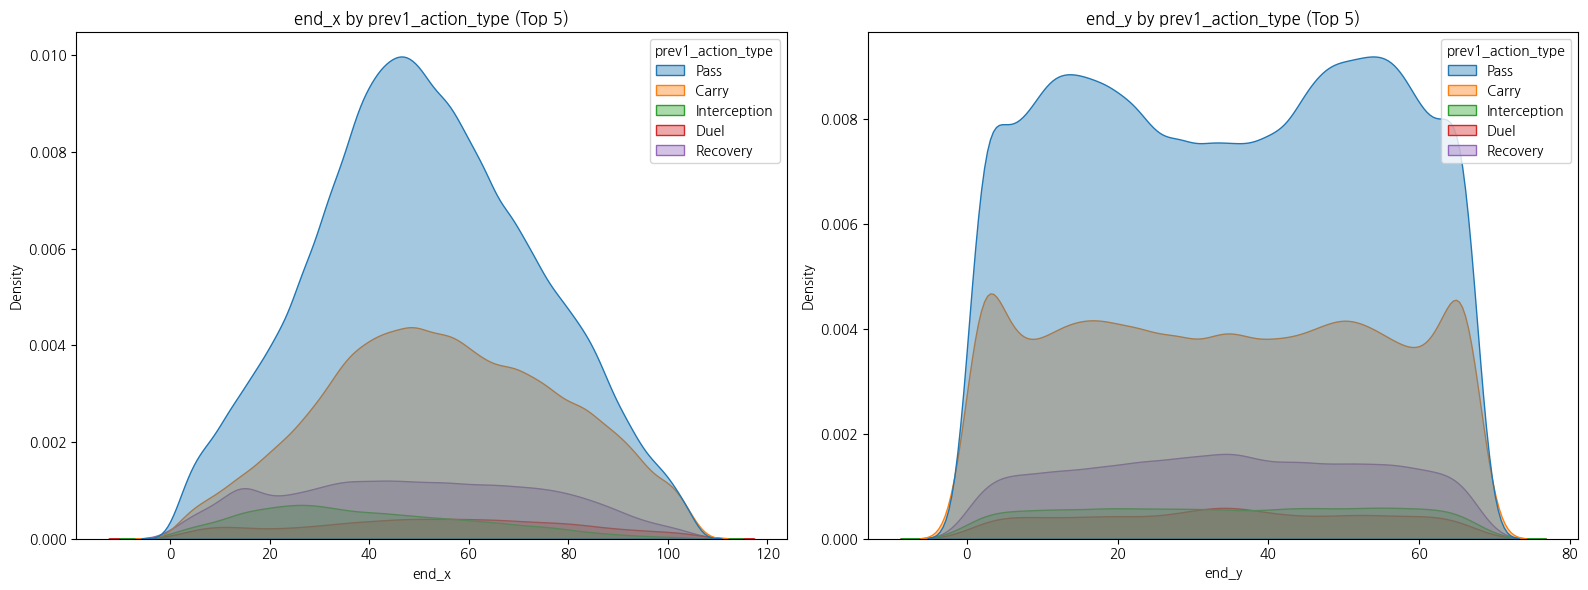

In [15]:
#df_copy 1-step의 상위 5개의 type_name의 행동 분포확인
# Top 5 prev_action_type 선택
topN = df_copy["prev1_action_type"].value_counts().head(5).index.tolist()
plot = df_copy[df_copy["prev1_action_type"].isin(topN)]

# Figure & subplots 준비
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) end_x KDE
sns.kdeplot(
    data=plot, x="end_x", hue="prev1_action_type",
    fill=True, alpha=0.4, ax=axes[0]
)
axes[0].set_title("end_x by prev1_action_type (Top 5)")

# 2) end_y KDE
sns.kdeplot(
    data=plot, x="end_y", hue="prev1_action_type",
    fill=True, alpha=0.4, ax=axes[1]
)
axes[1].set_title("end_y by prev1_action_type (Top 5)")

plt.tight_layout()
plt.show()

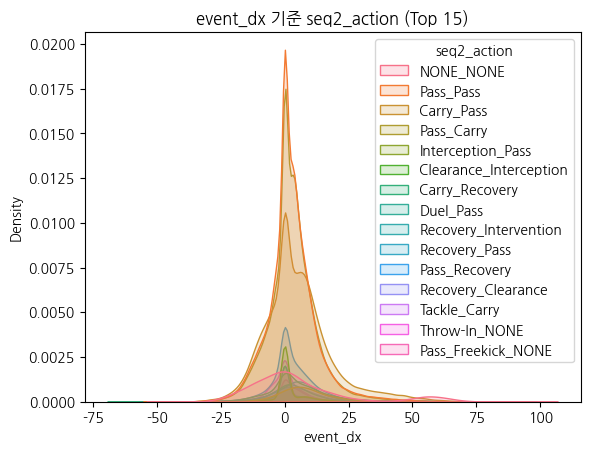

In [16]:
#1-step + 2-step 조합
df_copy["prev2_action_type"] =df_copy.groupby("game_episode")["action_type"].shift(2)

df_copy["prev1_action_type"]  = df_copy["prev1_action_type"].fillna("NONE")
df_copy["prev2_action_type"] = df_copy["prev2_action_type"].fillna("NONE")

df_copy["seq2_action"] = df_copy["prev1_action_type"] + "_" + df_copy["prev2_action_type"]

#EDA용 dx,dy
df_copy["event_dx"] = df_copy["end_x"] - df_copy["start_x"]
df_copy["event_dy"] = df_copy["end_y"] - df_copy["start_y"]

# seq2_action 상위 15개 분포 확인 (event_dx기준)
topK = df_copy["seq2_action"].value_counts().head(15).index.tolist()
df_top = df_copy[df_copy["seq2_action"].isin(topK)]
sns.kdeplot(data=df_top, x="event_dx", hue="seq2_action", fill=True, alpha=0.2)
plt.title('event_dx 기준 seq2_action (Top 15)')
plt.show()

#seq2_action_top 변수 df에 추가
df_copy["seq2_action_top"] = df_copy["seq2_action"].where(df_copy["seq2_action"].isin(topK), "OTHER")

#사용안하는 변수 삭제
df_copy = df_copy.drop(columns=["event_dx", "event_dy", "seq2_action"])

In [17]:
# 2. DL/Goal/Penalty Features 추가
def add_dl_features(df):
    # 이전 시작 위치
    df['prev_start_x'] = df.groupby('game_episode')['start_x'].shift(1)
    df['prev_start_y'] = df.groupby('game_episode')['start_y'].shift(1)

    dx = df['start_x'] - df['prev_start_x'] # Series
    dy = df['start_y'] - df['prev_start_y'] # Series

    # 현재 시간 - 과거 시간
    dt = df['time_seconds'] - df.groupby('game_episode')['time_seconds'].shift(1)
    dt = dt.fillna(1.0).replace(0, 0.1)

    # 속도 계산
    df['legal_speed'] = np.sqrt(dx**2 + dy**2) / dt
    df['legal_speed'] = df['legal_speed'].fillna(0.0)
    #print("50m/s 초과하는 이상치 개수:", (df['legal_speed'] > 50).sum())
    #df.loc[df['legal_speed'] > 50, 'legal_speed'] = 50

    # 각도 없이 속도만 넣을 경우 predict = 16m
    # 각도 포함하여 계산할 경우 16 -> 14.05까지 Down
    df['move_angle'] = np.arctan2(dy, dx)
    df['move_angle_sin'] = np.sin(df['move_angle']).fillna(0.0)
    df['move_angle_cos'] = np.cos(df['move_angle']).fillna(0.0)

    df['x_zone'] = (df['start_x'] / (105 / 7)).astype(int).clip(0, 6)
    df['y_lane'] = pd.cut(
        df['start_y'],
        bins=[0, 68/3, 2*68/3, 68],
        labels=[0, 1, 2],
        include_lowest=True
    ).astype(int)

    # Goal Value 패널티 박스 플레이 가정
    OPP_GOAL_X, OPP_GOAL_Y = 105, 34
    df['dist_to_opp_goal'] = np.sqrt((df['start_x'] - OPP_GOAL_X)**2 + (df['start_y'] - OPP_GOAL_Y)**2)
    df['angle_to_opp_goal'] = np.arctan2(OPP_GOAL_Y - df['start_y'], OPP_GOAL_X - df['start_x'])
    df['angle_to_opp_goal_sin'] = np.sin(df['angle_to_opp_goal']).fillna(0.0)
    df['angle_to_opp_goal_cos'] = np.cos(df['angle_to_opp_goal']).fillna(0.0)

    PENALTY_LINE_X = 105 - 16.5  # 88.5m
    PENALTY_CENTER_Y = 34
    df['dist_to_opp_box_center'] = np.sqrt(
        (df['start_x'] - PENALTY_LINE_X)**2 + (df['start_y'] - PENALTY_CENTER_Y)**2
    )

    # 추가: 에피소드 내 이벤트 순번 (0, 1, 2, ...)
    df['episode_event_index'] = df.groupby('game_episode').cumcount()

    return df

df_copy = add_dl_features(df_copy)

# 실제 시간 추가
df_copy["match_minutes"] = df_copy["time_seconds"]/60 + (df_copy["period_id"]-1)*45

df_copy.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,action_type,result_name,start_x,...,move_angle_cos,x_zone,y_lane,dist_to_opp_goal,angle_to_opp_goal,angle_to_opp_goal_sin,angle_to_opp_goal_cos,dist_to_opp_box_center,episode_event_index,match_minutes
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,...,0.000000,3,1,52.584313,0.009786,0.009785,0.999952,36.085464,0,0.011117
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,...,-0.975361,2,1,73.101872,-0.056127,-0.056097,0.998425,56.635419,1,0.061117
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,...,0.582957,2,1,67.712480,0.049746,0.049725,0.998763,51.239461,2,0.082800
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,...,0.167104,2,1,67.266604,0.140004,0.139547,0.990215,50.980073,3,0.136667
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,...,-0.201285,2,0,75.762127,0.377727,0.368809,0.929505,60.730940,4,0.193883


In [18]:
# =============================================================================
# 1. 공간 및 지역 피처 (Spatial & Zone Features)
# 의도: 현재 공의 위치가 경기장의 어느 구역이며, 골대와 얼마나 인접해 있는가?
# =============================================================================
def add_spatial_features(df):
    # [구역화] 경기장 가로(105m)를 7등분: 0(우리쪽 골대) ~ 6(상대쪽 골대)
    # 어떤 지역에서 패스가 주로 시작되는지 파악
    df['x_zone'] = (df['start_x'] / (105 / 7)).astype(int).clip(0, 6)

    # [레인화] 경기장 세로(68m)를 3등분: 0(좌측), 1(중앙), 2(우측)
    # 측면 공격인지 중앙 빌드업인지 구분
    df['y_lane'] = pd.cut(df['start_y'], bins=[0, 68/3, 2*68/3, 68],
                          labels=[0, 1, 2], include_lowest=True).astype(int)

    # [공격 거리] 상대 골대 중앙(105, 34)까지의 직선 거리
    # 거리가 가까울수록 슛이나 결정적인 패스 확률 증가
    df['dist_to_opp_goal'] = np.sqrt((df['start_x'] - 105)**2 + (df['start_y'] - 34)**2)

    # [수비 거리] 우리 골대 중앙(0, 34)까지의 직선 거리
    # 우리 진영 깊숙한 곳인지 확인 (위험 지역에서의 빌드업 판단)
    df['dist_to_my_goal'] = np.sqrt((df['start_x'] - 0)**2 + (df['start_y'] - 34)**2)

    # [박스 타겟] 상대 패널티 박스 정면(88.5, 34)과의 거리
    # 찬스 메이킹이 일어나는 핵심 지역과의 인접도
    df['dist_to_opp_box_center'] = np.sqrt((df['start_x'] - 88.5)**2 + (df['start_y'] - 34)**2)

    # [사이드라인] 현재 위치에서 가장 가까운 터치라인까지의 거리
    # 압박을 받기 쉬운 가장자리인지, 자유로운 중앙인지 판단
    df['dist_to_sideline'] = df['start_y'].apply(lambda y: min(y, 68 - y))

    return df

# =============================================================================
# 2. 물리 및 동적 흐름 피처 (Physics & Flow Features)
# 의도: 이전 동작으로부터 현재까지 공과 선수가 어떻게 이동(가속/방향전환)했는가?
# =============================================================================
def add_physics_features(df):
    # [직전 좌표] 바로 직전 이벤트의 시작 위치를 가져옴
    df['prev_start_x'] = df.groupby('game_episode')['start_x'].shift(1)
    df['prev_start_y'] = df.groupby('game_episode')['start_y'].shift(1)

    # [변위] 이전 위치에서 현재 위치까지의 x, y축 이동 거리
    dx = df['start_x'] - df['prev_start_x']
    dy = df['start_y'] - df['prev_start_y']

    # [시간차] 이벤트 사이의 경과 시간 (나눗셈 에러 방지를 위해 최소 0.1초 설정)
    dt = (df['time_seconds'] - df.groupby('game_episode')['time_seconds'].shift(1)).fillna(1.0).replace(0, 0.1)

    # [이동 속도] 단위 시간당 이동 거리 (m/s)
    # 역습 상황처럼 빠르게 전진 중인지, 지공 상황인지 구분
    df['legal_speed'] = (np.sqrt(dx**2 + dy**2) / dt).fillna(0.0)

    # [이동 각도] 현재 이동 중인 방향을 라디안 각도로 계산
    move_angle = np.arctan2(dy, dx)
    # [각도 분해] 모델이 각도의 연속성을 이해하도록 Sin/Cos 값으로 변환
    # (예: 359도와 1도는 수치상 멀지만 물리적으론 가깝기 때문)
    df['move_angle_sin'] = np.sin(move_angle).fillna(0.0)
    df['move_angle_cos'] = np.cos(move_angle).fillna(0.0)

    return df

# =============================================================================
# 3. 과거 맥락(Lag) 피처 (Sequence Context Features)
# 의도: 지금 패스하기 직전 3단계 동안 어떤 일이 있었는가? (흐름 파악)
# =============================================================================
def add_lag_features(df, n_shifts=3):
    # 추적 항목: 종료 위치(x, y), 행동 종류(action), 성공 여부(result)
    base_cols = ["end_x", "end_y", "action_type", "result_name"]
    grp = df.groupby("game_episode")

    for k in range(1, n_shifts + 1):
        # [과거 데이터] k단계 전의 기록을 현재 시점으로 당겨옴
        shifted = grp[base_cols].shift(k)
        shifted.columns = [f"prev{k}_{c}" for c in base_cols]
        df = pd.concat([df, shifted], axis=1)

        # [결측 보정] 에피소드 시작 시점이라 과거가 없다면 현재 시작 위치로 채움
        df[f'prev{k}_end_x'] = df[f'prev{k}_end_x'].fillna(df['start_x'])
        df[f'prev{k}_end_y'] = df[f'prev{k}_end_y'].fillna(df['start_y'])

    return df

# =============================================================================
# 4. 에피소드 누적 피처 (Episode Aggregation Features)
# 의도: 이번 공격권(에피소드) 내에서 팀이 보여준 전체적인 데이터 요약
# =============================================================================
def add_agg_features(df):
    grp = df.groupby("game_episode")

    # [진행 순서] 에피소드 내 현재 행동의 인덱스 (초반 빌드업인지 후반부인지)
    df['episode_event_index'] = grp.cumcount()

    # [총 행동수] 이번 에피소드에서 총 몇 번의 터치가 일어났는지 (공격의 길이)
    df['episode_len'] = grp['action_id'].transform('count')

    # [패스 횟수] 현재 에피소드 내 누적 패스 성공 횟수 (팀의 패스 성향)
    df['n_pass'] = grp['action_type'].transform(lambda x: (x == 'Pass').sum())

    # [드리블 횟수] 현재 에피소드 내 누적 드리블(Carry) 횟수 (개인 전술 비중)
    df['n_carry'] = grp['action_type'].transform(lambda x: (x == 'Carry').sum())

    return df

In [19]:
df_copy["prev1_dx"] = df_copy["prev1_end_x"] - df_copy["start_x"]
df_copy["prev1_dy"] = df_copy["prev1_end_y"] - df_copy["start_y"]
df_copy["prev1_dist"] = np.sqrt(df_copy["prev1_dx"]**2 + df_copy["prev1_dy"]**2)

theta = np.arctan2(df_copy["prev1_dy"], df_copy["prev1_dx"])
df_copy["prev1_angle_sin"] = np.sin(theta)
df_copy["prev1_angle_cos"] = np.cos(theta)

In [20]:
#측면 전용 피처 (is_wing은 사용 X)
df_copy["is_wing"] = (df_copy["start_y"] < 10) | (df_copy["start_y"] > 58)
df_copy["wing_prev_dy"] = df_copy["prev1_dy"] * df_copy["is_wing"]

df_copy["wing_prev_angle_sin"] = df_copy["prev1_angle_sin"] * df_copy["is_wing"]
df_copy["wing_prev_angle_cos"] = df_copy["prev1_angle_cos"] * df_copy["is_wing"]

## 모델 실험 및 추론

### 데이터 확인

In [21]:
df_copy.columns

Index(['game_id', 'period_id', 'episode_id', 'time_seconds', 'team_id',
       'player_id', 'action_id', 'action_type', 'result_name', 'start_x',
       'start_y', 'end_x', 'end_y', 'is_home', 'game_episode', 'is_train',
       'game_day', 'game_date', 'home_score', 'away_score', 'venue',
       'home_team_name_ko', 'away_team_name_ko', 'player_role_pass',
       'player_role_label', 'prev1_end_x', 'prev1_end_y', 'prev1_action_type',
       'prev1_result_name', 'prev2_action_type', 'seq2_action_top',
       'prev_start_x', 'prev_start_y', 'legal_speed', 'move_angle',
       'move_angle_sin', 'move_angle_cos', 'x_zone', 'y_lane',
       'dist_to_opp_goal', 'angle_to_opp_goal', 'angle_to_opp_goal_sin',
       'angle_to_opp_goal_cos', 'dist_to_opp_box_center',
       'episode_event_index', 'match_minutes', 'prev1_dx', 'prev1_dy',
       'prev1_dist', 'prev1_angle_sin', 'prev1_angle_cos', 'is_wing',
       'wing_prev_dy', 'wing_prev_angle_sin', 'wing_prev_angle_cos'],
      dtype='object')

In [22]:
df_copy.isnull().sum()

,0
game_id,0
period_id,0
episode_id,0
time_seconds,0
team_id,0
player_id,0
action_id,0
action_type,0
result_name,161383
start_x,0


### 모델 학습 및 추론

In [25]:
# 전처리 & 학습 함수 정의
def add_episode_len(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["episode_len"] = df.groupby("game_episode")["action_id"].transform("count")
    return df

def split_train_test(df: pd.DataFrame, flag_col="is_train"):
    df_train = df[df[flag_col] == 1].copy()
    df_test  = df[df[flag_col] == 0].copy()
    return df_train, df_test

def sort_df(df: pd.DataFrame) -> pd.DataFrame:
    return df.sort_values(Config.SORT_KEYS).reset_index(drop=True)

def get_last_event_per_episode(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.sort_values(Config.SORT_KEYS)
          .groupby("game_episode", as_index=False)
          .tail(1)
          .reset_index(drop=True)
    )

def filter_train_targets(df: pd.DataFrame) -> pd.DataFrame:
    cond = df["end_x"].notnull() & df["end_y"].notnull()
    return df[cond].reset_index(drop=True)

def build_feature_cols(df: pd.DataFrame):
  # 존재하는 컬럼만 + 드랍 대상 제거 + 중복 제거
    cols = [c for c in Config.FEATURES if c in df.columns]
    cols = [c for c in cols if c not in Config.DROP_COLS]
    return list(dict.fromkeys(cols))


def build_cat_features(feature_cols: list) -> list:
    return [c for c in Config.CAT_FEATURES if c in feature_cols]

def fill_missing(X_train: pd.DataFrame, X_test: pd.DataFrame, cat_features: list):
    X_train = X_train.copy()
    X_test  = X_test.copy()

    # 범주형: 문자열화 + Missing
    for c in cat_features:
        X_train[c] = X_train[c].astype(str).fillna("Missing")
        X_test[c]  = X_test[c].astype(str).fillna("Missing")

    # numeric (의미상 0이 안전한 것만)
    for c in ["dx", "dy", "legal_speed"]:
        if c in X_train.columns:
            X_train[c] = X_train[c].fillna(0.0)
            X_test[c]  = X_test[c].fillna(0.0)

    return X_train, X_test

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from catboost import CatBoostRegressor

# =============================================================================
# 1. 기본 config 파일 생성
# =============================================================================

class Config:
    SEED = 42
    N_FOLDS = 5
    CLIP_X = (0, 105)
    CLIP_Y = (0, 68)

    # Base 모델 (기본 예측)
    BASE_PARAMS = {
        'depth': 9, 'learning_rate': 0.05, 'iterations': 1500,
        'loss_function': 'RMSE', 'early_stopping_rounds': 100,
        'random_seed': 42,
        'verbose': 200
    }

    # Fixer 모델 (오차 보정용)
    FIXER_PARAMS = {
        'depth': 6, 'learning_rate': 0.03, 'iterations': 1000,
        'loss_function': 'MAE', # 오차 학습엔 MAE가 유리
        'early_stopping_rounds': 100,
        'random_seed': 42,
        'verbose': 200
    }

    DROP_COLS = [
        "game_id", "period_id", "episode_id", "game_episode",
        "time_seconds", "is_train", "action_id",
        "team_id", "player_id", "venue", "game_day", "game_date",
        "home_team_name_ko", "away_team_name_ko", "is_home",
        "home_score", "away_score",
        "prev_start_x", "prev_start_y",
        "move_angle", "angle_to_opp_goal",
        "dist_to_opp_box_center", "action_type", "prev2_action_type"
    ]

    FEATURES = [
        "match_minutes", "episode_event_index", "seq2_action_top",
        "start_x", "start_y", "legal_speed", "move_angle_sin", "move_angle_cos",
        "prev1_end_x", "prev1_end_y", "x_zone", "y_lane",
        "dist_to_opp_goal", "angle_to_opp_goal_sin", "angle_to_opp_goal_cos",
        "result_name", "prev1_action_type", "prev1_result_name",
        "player_role_label", 'player_role_pass',
        'prev1_dx', 'prev1_dy', 'prev1_dist', 'prev1_angle_sin', 'prev1_angle_cos',
        'wing_prev_dy', 'wing_prev_angle_sin', 'wing_prev_angle_cos',
#        'dist_to_far_side', 'deep_clearance_potential', 'cross_potential'
#        FEATURES 그대로 유지해서 성능 비교하기 위해
    ]

    CAT_FEATURES = [
    "result_name",
    "player_role_label",
    "seq2_action_top",
    "prev1_action_type",
    "prev1_result_name",
    "x_zone", "y_lane",
    "player_role_pass",
    ]

    SORT_KEYS = ["game_episode", "time_seconds", "action_id"]
    TARGETS = ["end_x", "end_y"]

# =============================================================================
# 2. [전처리] 데이터 준비 (메모리 사용)
# =============================================================================
# 일부로 3개 변수 추가한 거 주석처리 피처 똑같이 하기 위해서
# 변수 3개 없애니까 13.193으로 성능 더 올라감 피처를 추가하는 것이 더 떨어짐

def build_dataset(df_copy):
    print("[Data] Residual Learning 데이터셋 구축 중...")

    # 변수 생성
#    df_copy['dist_to_far_side'] = 68 - df_copy['start_y']
#    df_copy['deep_clearance_potential'] = ((df_copy['player_role_label'] == 'defence') & (df_copy['start_x'] < 35)).astype(int)
#    df_copy['cross_potential'] = ((df_copy['start_x'] > 70) & ((df_copy['start_y'] < 15) | (df_copy['start_y'] > 53))).astype(int)

    df = add_episode_len(df_copy)
    df_train, df_test = split_train_test(df, "is_train")
    df_train, df_test = sort_df(df_train), sort_df(df_test)
    train_epi = filter_train_targets(get_last_event_per_episode(df_train))
    test_epi  = get_last_event_per_episode(df_test)

    groups = train_epi["game_id"].values  # 경기 단위 그룹

    cat_features = build_cat_features(Config.FEATURES)
    X_train = train_epi[Config.FEATURES].copy()
    X_test  = test_epi[Config.FEATURES].copy()
    X_train, X_test = fill_missing(X_train, X_test, cat_features)

    # 이동량으로 예측하기 위해
    y_dx = train_epi["end_x"].values - train_epi["start_x"].values
    y_dy = train_epi["end_y"].values - train_epi["start_y"].values

    return X_train, X_test, y_dx, y_dy, groups, test_epi, cat_features

# =============================================================================
# 3. [학습] 점수 계산
# =============================================================================
def train_residual_pipeline(X_train, y_dx, y_dy, X_test, groups, cat_features):
    gkf = GroupKFold(n_splits=Config.N_FOLDS)

    # Base 모델 예측값 저장소
    oof_base_dx = np.zeros(len(X_train))
    oof_base_dy = np.zeros(len(X_train))
    test_base_dx = np.zeros(len(X_test))
    test_base_dy = np.zeros(len(X_test))

    print("\n=====  [Step 1] Base Model (기본 예측) 학습 시작 =====")
    for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_train, y_dx, groups=groups), 1):
        print(f"\n--- Base Model Fold {fold} ---")
        model_dx = CatBoostRegressor(**Config.BASE_PARAMS)
        model_dy = CatBoostRegressor(**Config.BASE_PARAMS)

        # Base 학습 (verbose 켜짐)
        model_dx.fit(X_train.iloc[tr_idx], y_dx[tr_idx], eval_set=[(X_train.iloc[va_idx], y_dx[va_idx])], cat_features=cat_features)
        model_dy.fit(X_train.iloc[tr_idx], y_dy[tr_idx], eval_set=[(X_train.iloc[va_idx], y_dy[va_idx])], cat_features=cat_features)

        oof_base_dx[va_idx] = model_dx.predict(X_train.iloc[va_idx])
        oof_base_dy[va_idx] = model_dy.predict(X_train.iloc[va_idx])

        test_base_dx += model_dx.predict(X_test) / Config.N_FOLDS
        test_base_dy += model_dy.predict(X_test) / Config.N_FOLDS

    # 오차(Residual) 계산
    resid_dx = y_dx - oof_base_dx
    resid_dy = y_dy - oof_base_dy

    print("\n===== [Step 2] Fixer Model (오차 보정) 학습 시작 =====")
    # Fixer 모델 예측값 저장소
    oof_fix_dx = np.zeros(len(X_train))
    oof_fix_dy = np.zeros(len(X_train))
    test_fix_dx = np.zeros(len(X_test))
    test_fix_dy = np.zeros(len(X_test))

    for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_train, resid_dx, groups=groups), 1):
        print(f"\n--- Fixer Model Fold {fold} ---")
        fixer_dx = CatBoostRegressor(**Config.FIXER_PARAMS)
        fixer_dy = CatBoostRegressor(**Config.FIXER_PARAMS)

        # 오차 학습 (verbose 켜짐)
        fixer_dx.fit(X_train.iloc[tr_idx], resid_dx[tr_idx], eval_set=[(X_train.iloc[va_idx], resid_dx[va_idx])], cat_features=cat_features)
        fixer_dy.fit(X_train.iloc[tr_idx], resid_dy[tr_idx], eval_set=[(X_train.iloc[va_idx], resid_dy[va_idx])], cat_features=cat_features)

        oof_fix_dx[va_idx] = fixer_dx.predict(X_train.iloc[va_idx])
        oof_fix_dy[va_idx] = fixer_dy.predict(X_train.iloc[va_idx])

        test_fix_dx += fixer_dx.predict(X_test) / Config.N_FOLDS
        test_fix_dy += fixer_dy.predict(X_test) / Config.N_FOLDS

    # 최종 점수 계산
    final_oof_dx = oof_base_dx + oof_fix_dx
    final_oof_dy = oof_base_dy + oof_fix_dy

    err_x = (y_dx - final_oof_dx) ** 2
    err_y = (y_dy - final_oof_dy) ** 2
    rmse_x = np.sqrt(np.mean(err_x))
    rmse_y = np.sqrt(np.mean(err_y))
    score = np.mean(np.sqrt(err_x + err_y))

    print(f"\n[RMSE_x]: {rmse_x:.4f}m")
    print(f"\n[RMSE_y]: {rmse_y:.4f}m")
    print(f"\n[OOF] 최종 예상 점수: {score:.4f}m")

    if score < 13.43:
        print("성공! 13.43(Best)보다 좋다!")
    else:
        print("아쉽지만 기존 모델이 성능 낮음")

    return test_base_dx + test_fix_dx, test_base_dy + test_fix_dy
# =============================================================================
# 4. 실행
# =============================================================================
X_train, X_test, y_dx, y_dy, groups, test_epi, cat_features = build_dataset(df_copy)
pred_dx, pred_dy = train_residual_pipeline(X_train, y_dx, y_dy, X_test, groups, cat_features)

final_pred_x = np.clip(test_epi["start_x"].values + pred_dx, *Config.CLIP_X)
final_pred_y = np.clip(test_epi["start_y"].values + pred_dy, *Config.CLIP_Y)

submission = pd.DataFrame({
    "game_episode": test_epi["game_episode"].values,
    "end_x": final_pred_x,
    "end_y": final_pred_y,
})

filename = "submission_residual_correction.csv"
submission.to_csv(filename, index=False)
print(f" 저장 완료: {filename}")

[Data] Residual Learning 데이터셋 구축 중...

=====  [Step 1] Base Model (기본 예측) 학습 시작 =====

--- Base Model Fold 1 ---
0:	learn: 15.8603079	test: 15.7789942	best: 15.7789942 (0)	total: 128ms	remaining: 3m 11s
200:	learn: 10.6277156	test: 11.6452729	best: 11.6452729 (200)	total: 16.3s	remaining: 1m 45s
400:	learn: 9.5648886	test: 11.5772500	best: 11.5756253 (385)	total: 34.4s	remaining: 1m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 11.57374854
bestIteration = 448

Shrink model to first 449 iterations.
0:	learn: 14.8941099	test: 14.6848049	best: 14.6848049 (0)	total: 73.7ms	remaining: 1m 50s
200:	learn: 11.4166744	test: 12.3094121	best: 12.3094121 (200)	total: 16.1s	remaining: 1m 43s
400:	learn: 10.2804395	test: 12.2353212	best: 12.2225631 (352)	total: 32.9s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 12.22256308
bestIteration = 352

Shrink model to first 353 iterations.

--- Base Model Fold 2 ---
0:	learn: 15.8127988	test: 1